# Kafka + Spark Structured Streaming

Kafka can be integrated relatively easily with Spark streaming APIs to act as either a `source` or a `sink` for the streaming data.

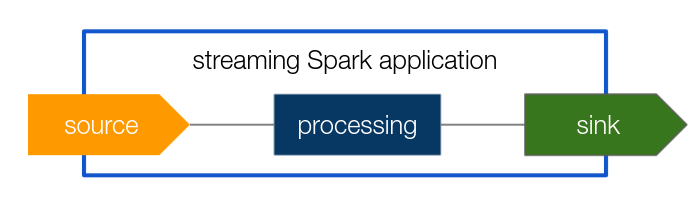

However, pySpark also enables stream processing with `Structured Streaming`.

Spark Streaming discretizes the input data stream into micro-batches of RDDs (`DStream`), which can later be treated as static RDDs.

Spark Structured Streaming, on the other hand, is intended to be used with the DataFrame API. There is no strict batch concept, as new data can be seen as new rows of an unbounded table.

Three DataFrame increment modes are available in Spark Structured Streaming:
- Complete: The entire structured "Table" received from the source is written to the sink.
- Append: Only the new rows appended since the last trigger will be written.
- Update: Only the rows that were updated since the last trigger will be written.

In [ ]:
# define the list of brokers in the cluster
KAFKA_BOOTSTRAP_SERVERS = 'kafka-broker:9092'

In [ ]:
import os
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("spark://spark-master:7077")\
    .appName("Spark structured streaming application")\
    .config("spark.executor.memory", "512m")\
    .config("spark.sql.execution.arrow.pyspark.enabled", "true")\
    .config("spark.sql.adaptive.enabled", "false")\
    .config("spark.sql.execution.arrow.pyspark.fallback.enabled", "false")\
    .config("spark.sql.shuffle.partitions", 4)\
    .config("spark.jars.packages","org.apache.spark:spark-sql-kafka-0-10_2.12:3.3.2")\
    .getOrCreate()

In [ ]:
sc = spark.sparkContext
sc

## Read data from Kafka

First, we create a DataFrame representing the stream of input lines from Kafka by connecting to the appropriate servers and topic.

`readStream` and `format("kafka")` are the key components for connecting to the data source.

In [ ]:
inputDF = spark\
    .readStream\
    .format("kafka")\
    .option("kafka.bootstrap.servers", KAFKA_BOOTSTRAP_SERVERS)\
    .option("kafkaConsumer.pollTimeoutMs", 4000)\
    .option("startingOffsets", "latest") \
    .option("subscribe", "a_partitioned_topic")\
    .load()    

At this stage, nothing happens because the streaming has not started yet. We have only defined the source of the streaming application.

The `inputDF` can be treated as if it were a static DataFrame in Spark, **but** it is a streaming DataFrame that continuously grows.

In [ ]:
inputDF.isStreaming

Currently, `inputDF` contains the messages from Kafka, which are further composed of a `<key, value>` pair, a timestamp, and other information.

In [ ]:
inputDF.printSchema()

We are clearly interested in the `value` of the message, which is in JSON format.

We can utilize the `pyspark.sql` functions to define a schema for our structured data and interpret the data accordingly.

In [ ]:
from pyspark.sql.functions import from_json, col
from pyspark.sql.types import StructField, StructType, StringType, DoubleType, IntegerType

# the schema of the json data format used to create the messages
schema = StructType(
        [
                StructField("name", StringType()),
                StructField("surname", StringType()),
                StructField("amount", StringType()),
                StructField("delta_t", StringType()),
                StructField("flag", IntegerType())
        ]
)

# a new DF can be created from the previous by using the pyspark.sql functions
jsonDF = inputDF.select(from_json(
                            col("value").alias('value').cast("string"), 
                            schema
                        ).alias('value')
                       )

In [ ]:
jsonDF.printSchema()

It's possible to inspect the data actually reaching the `jsonDF` by starting a stream with a `console` sink. 
The output of the streaming processing in this case will be displayed in the shell running the Jupyter Notebook.

We should expect a DataFrame with a single column, containing a JSON-like object per message.

In [ ]:
# jsonDF.writeStream\
#     .outputMode("append")\
#     .format("console")\
#     .start()\
#     .awaitTermination()

To flatten the `jsonDF` into a proper DataFrame, we can rely on `selectExpr`, which projects a nested field (using SQL-like expressions) and returns a new DataFrame. You can refer to the [docs](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.selectExpr.html) for more information.


In [ ]:
flatDF = jsonDF.selectExpr("value.name", 
                           "value.surname", 
                           "value.amount",
                           "value.delta_t",
                           "value.flag")

In [ ]:
flatDF.printSchema()

In [ ]:
# flatDF.writeStream\
#     .outputMode("append")\
#     .format("console")\
#     .start()\
#     .awaitTermination()

## Simple Fraud Detection + Kafka Sink

Let's integrate the same simplistic "fraud detection" logic we previously used in our Spark Streaming example.

We might be interested in having Spark perform the heavy lifting and then allowing other consumers to access the results of these operations. For example, we can display the results on a dashboard or trigger some action.

We can use Kafka as a sink for the resulting data.

In [ ]:
from pyspark.sql.functions import concat, col, lit, countDistinct

# find number of transactions for each user when flag = 1 
num_transactions = flatDF \
    .where(col('flag')==1) \
    .withColumn('id', concat(col('name'), col('surname'))) \
    .groupBy('id') \
    .count() 
    
# find suspicious transactions
sus_transactions = num_transactions \
    .where(col('count')>1) \
    .withColumn('fraud', lit(1)) \
    .select(col("id").alias("key"),
            col("fraud").cast(StringType()).alias("value"))

At this point, it may seem that these newly derived DataFrames are not connected in any way or form to the input streaming Kafka source.

However, we can verify this by using the `isStreaming` method on a DataFrame.

In [ ]:
sus_transactions.isStreaming

In [ ]:
sus_transactions.printSchema()

The `sus_transactions` DataFrame is still a streaming DataFrame. It can be seen as the result of the transformations applied to the original `inputDF` derived from the streaming source.

In [ ]:
# sus_transactions.writeStream\
#     .outputMode("update")\
#     .format("console")\
#     .start()\
#     .awaitTermination()

Finally, let's wrap up the message and write it to a `results` topic back to Kafka, so that other consumers can make use of its data.

In [ ]:
sus_transactions.writeStream\
    .outputMode("update")\
    .format("kafka") \
    .option("kafka.bootstrap.servers", KAFKA_BOOTSTRAP_SERVERS) \
    .option("topic", "results") \
    .option("checkpointLocation", "checkpoint") \
    .option("failOnDataLoss", "false") \
    .start() \
    .awaitTermination()

## Stop worker and master

In [ ]:
# stop the running Spark context and Spark session
sc.stop()
spark.stop()

Finally, use `docker compose down` to stop and clear all running containers.